<a href="https://colab.research.google.com/github/michelemiko1/Paper_effects_chain/blob/main/1__paper_guitar_effetcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###LIBRARIES, RESOURCES AND UTILS

In [ ]:
# version of tensorflow used in this project
!pip install tensorflow==2.7
import tensorflow as tf
print(tf.__version__)

# GPU used
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# RAM how much
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.2f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.7/489.7 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow
    Foun

In [ ]:
import os
import librosa
import librosa.display
import json
import pickle
import numpy as np
import gc
import matplotlib.pyplot as plt

# constant values
SEGMENT_SECONDS = 2
SAMPLING_RATE = 22050
NUMBER_OF_SEGMENTS = 5
SEGMENT_LENGTH = SAMPLING_RATE * SEGMENT_SECONDS  # 44100

# dataset path (input)
# DATASET_PATH_VARY_PARAMS = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/1__dataset/separated_5effects_vary_param'
DATASET_PATH_VARY_PARAMS_POSITION = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/1__dataset/separated_5effects_vary_param_position'

# output path (output)
# DATASET_PATH_MEL_SPEC = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/1__dataset/preprocessed/mel_spec_5eff_vary_params.pickle'
DATASET_PATH_MEL_SPEC_POSITION = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/1__dataset/preprocessed/mel_spec_5eff_vary_params_position.pickle'
DATASET_PATH_MEL_SPEC_PARAM = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/1__dataset/preprocessed/mel_spec_5eff_vary_params.pickle'
DATASET_PATH_MEL_SPEC_FIXED = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/1__dataset/preprocessed/fixed_correct_s.pickle'


In [ ]:
# utils
import json
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import gc


def load_data_pickle(data_path):
  with open(data_path, "rb") as fp:
      data = pickle.load(fp)
  return data
  

# build and compile the model
def build_and_compile_model(indiv, input_shape, print_model=True):

  model = keras.Sequential()

  # create first conv layer + pooling layer
  model.add(keras.layers.Conv2D(filters=indiv[1], kernel_size=(indiv[2], indiv[3]), input_shape=input_shape, activation='relu', padding='same'))
  model.add(keras.layers.MaxPool2D(pool_size=(indiv[4], indiv[5]), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # create other conv layers + pooling layers
  remain_conv_layer = indiv[0] - 1
  for i in range(6, 6 + remain_conv_layer * 4, 5):
    model.add(keras.layers.Conv2D(filters=indiv[i], kernel_size=(indiv[i+1], indiv[i+2]), activation='relu', padding='same'))
    model.add(keras.layers.MaxPool2D(pool_size=(indiv[i+3], indiv[i+4]), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
  # flatten
  model.add(keras.layers.Flatten())

  # create dense layers + dropout
  dense_layers = indiv[26]  # how many dense layers we have
  for j in range(27, 27 + dense_layers * 2, 2):
    model.add(keras.layers.Dense(units=indiv[j], activation='relu'))
    model.add(keras.layers.Dropout(indiv[j+1]))

  # add final layer
  model.add(keras.layers.Dense(units=5, activation='sigmoid'))

  # compile the model
  optimizer = keras.optimizers.Adam(learning_rate=0.00005)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  if print_model:
    print(model.summary())

  return model


def prepare_dataset_for_guitar_cross_validation(data, test_guitar = 'tele'):

    # 64000 segments in total

    X_test = []
    y_test = []
    N_test = []

    X_train = []
    y_train = []
    N_train = []
    
    count_test = 0
    count_train = 0
    
    # i goes from 0 to 63999
    for i, name in enumerate(data['names']):
      if name[:3] == test_guitar[:3]:   
        
        X_test.append(data['spectrograms'][i])
        y_test.append(data['labels'][i])
        N_test.append(data['names'][i])
        count_test += 1

      else:

        X_train.append(data['spectrograms'][i])
        y_train.append(data['labels'][i])
        N_train.append(data['names'][i])
        count_train += 1

    print(f'train set: {count_train}')
    print(f'test set: {count_test} (guitar: {test_guitar})')

    # from list to numpy array 
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # add 3rd dimension
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_test, y_train, y_test, N_train, N_test



### PREPROCESSING

In [ ]:
# functions for preprocessing
def get_list_plugins(file_name):
    """returns the list of plugins associated to a specific audio file
    ex: les_bridge_fing01__01101.wav returns [0, 1, 1, 0, 1]"""

    # get only the string associated to plugin values es: '01101'
    file_name_part = file_name[-9: -4]
    list_plugins = []

    for number in file_name_part:
        if number == '0':
            list_plugins.append(0)
        if number == '1':
            list_plugins.append(1)
    return list_plugins


def print_path_folders_files_info(path, folders, files):
    print("\n\npath:", path)
    print("folders:", folders)
    print("how many files:", len(files))
    print("file example:", files[:3], end="\n\n")

def print_percentage_completion(count, total_files, step):
    if count % step == 0:
        print("progress", round(count/total_files, 2), "%")
    return count + 1

def prepare_dataset(dataset_path, mel_spec_path):
    """saves mel-spectrogram and label for each audio file (segment)"""

    data = {
        "names":[],
        "spectrograms": [],  # [ spec1, spec2, spec3, ...]
        "labels": []        # [ [0,0,0,1,0], [0,1,0,1,1], [1,1,1,0,0], ...]
    }
    files_count = 0

    count = 0
    for i, (path, folders, files) in enumerate(os.walk(dataset_path)):

        # path: /content/.../1__dataset/separated_5effects_vary_param
        # folders: ['les', 'prs', 'tele', 'str']
        # files: []

        if path is not dataset_path:

            print_path_folders_files_info(path, folders, files)
            
            for file_name in files:
                
                # monitor percentage of completion
                count = print_percentage_completion(count, 12800, 128)

                file_path = os.path.join(path, file_name)  # get the entire path
                audio_file, sr = librosa.load(file_path, sr=SAMPLING_RATE)  # load audio file                    
                y = get_list_plugins(file_name)  # get the current label
  
                # divide the signal into segments and store
                for segment_index in range(NUMBER_OF_SEGMENTS):

                    # divide signal into segments
                    segment_start = segment_index * SEGMENT_LENGTH
                    current_segment = audio_file[segment_start:segment_start + SEGMENT_LENGTH]

                    # get the mel spectrogram
                    mel_spectrogram = librosa.feature.melspectrogram(y=current_segment, sr=SAMPLING_RATE, n_fft=2048,
                                                                      hop_length=512, n_mels=128)
                    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
                    log_mel_spectrogram = log_mel_spectrogram.T

                    # save data      
                    current_name = file_name[:-4] + f'__segm{segment_index + 1}'             
                    data["spectrograms"].append(log_mel_spectrogram.tolist())
                    data["labels"].append(y)
                    data["names"].append(current_name)
                
    with open(mel_spec_path, "wb") as fb:
        pickle.dump(data, fb)

prepare_dataset(DATASET_PATH_VARY_PARAMS_POSITION, DATASET_PATH_MEL_SPEC_POSITION)

In [ ]:
# load dataset of mel spec
def load_data_pickle(data_path):
  with open(data_path, "rb") as fp:
      data = pickle.load(fp)
  return data
  
entire_dataset = load_data_pickle(DATASET_PATH_MEL_SPEC_POSITION)

indeces: [ 1430 23230 57717 16349  1677 47476]


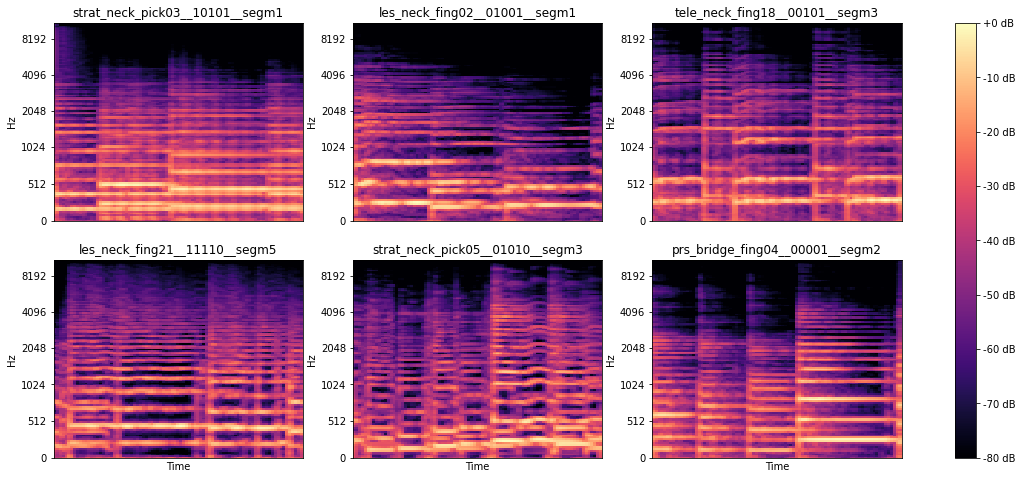

In [ ]:
# plotting 6 random mel spectrograms
dataset_length = len(entire_dataset["labels"])

indeces = np.random.randint(dataset_length, size=6)  # ex. [ 9467 43814 58297  3831 29183 55152]
print("indeces:", indeces)

spectrograms = []
labels = []

# save names and spectrograms (transposing them)
for index in indeces:
  spectrogram = np.array(entire_dataset["spectrograms"][index]).T
  spectrograms.append(spectrogram)

  label = entire_dataset["names"][index]
  labels.append(label)

# position of each spectrgram in the figure
index_config = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)] 

# plot the spectrograms
fig, ax = plt.subplots(2, 3, figsize=(19, 8))
for i in range(6):
  img = librosa.display.specshow(spectrograms[i], y_axis='mel', sr=22050, fmax=11050, ax=ax[index_config[i]])
  img = librosa.display.specshow(spectrograms[i] - np.max(spectrograms[i]), y_axis='mel', sr=22050, fmax=11050, ax=ax[index_config[i]]) #max=0db
  ax[index_config[i]].set(title=labels[i])

ax[1, 0].set_xlabel("Time")
ax[1, 1].set_xlabel("Time")
ax[1, 2].set_xlabel("Time")
fig.colorbar(img, ax=ax, format='%+2.0f dB')

# save graph 
save_path_mel_spec = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/4__plots/mel_spec_examples_300_black.png'
#plt.savefig(save_path_mel_spec)
plt.savefig(save_path_mel_spec, dpi=300)

plt.show()

In [ ]:
def investigate_data(data):

  # verify some informations about data dictionary
  print(f"type of data is: {type(data)}")
  print(f"dictionary keys of dict are: {data.keys()}")

  # shape
  print(f"shape of data['spectrograms'] is: {np.shape(data['spectrograms'])}")
  print(f"shape of data['labels'] is: {np.shape(data['labels'])}")

  # length
  print(f"len of data['spectrograms'] is: {len(data['spectrograms'])}")
  print(f"len of data['labels'] is: {len(data['labels'])}")

  # type
  print(f"type of data['spectrograms'] is: {type(data['spectrograms'])}")
  print(f"type of data['labels'] is: {type(data['labels'])}")

  # one element
  print(f"one element in data['names'] is: {data['names'][12]}")
  print(f"one element in data['spectrograms'] is: {data['spectrograms'][12]}")
  print(f"one element in data['labels'] is: {data['labels'][12]}")

investigate_data(entire_dataset)

In [ ]:
# MODIFY NAME spectrogram into spectrograms!!

# # view structure of fixed dataset
# entire_dataset_1_fixed = load_data_pickle(DATASET_PATH_MEL_SPEC_FIXED)

# # export fixed dataset (dataset 1) with correction spectrogram -> spectrograms
# #dictionary[new_key] = dictionary.pop(old_key)
# print(entire_dataset_1_fixed.keys())

# entire_dataset_1_fixed['spectrograms'] = entire_dataset_1_fixed.pop('spectrogram')

# def investigate_data(data):

#   # verify some informations about data dictionary
#   print(f"type of data is: {type(data)}")
#   print(f"dictionary keys of dict are: {data.keys()}")

#   # shape
#   print(f"shape of data['spectrograms'] is: {np.shape(data['spectrograms'])}")
#   print(f"shape of data['labels'] is: {np.shape(data['labels'])}")

#   # length
#   print(f"len of data['spectrograms'] is: {len(data['spectrograms'])}")
#   print(f"len of data['labels'] is: {len(data['labels'])}")

#   # type
#   print(f"type of data['spectrograms'] is: {type(data['spectrograms'])}")
#   print(f"type of data['labels'] is: {type(data['labels'])}")

#   # one element
#   print(f"one element in data['names'] is: {data['names'][12]}")
#   print(f"one element in data['spectrograms'] is: {data['spectrograms'][12]}")
#   print(f"one element in data['labels'] is: {data['labels'][12]}")

# investigate_data(entire_dataset_1_fixed)


# #new_path = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/1__dataset/preprocessed/fixed_correct_s.pickle'

# #with open(new_path, "wb") as fb:
# #  pickle.dump(entire_dataset_1_fixed, fb)


### BASIC CLASSIFICATION

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score


# load dataset of mel spec
def load_data_pickle(data_path):
  with open(data_path, "rb") as fp:
      data = pickle.load(fp)
  return data
  

def divide_dataset_into_train_test(data):
    X = np.array(data["spectrograms"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def verify_input_shape(file):
    shape = np.shape(file)
    print(f"X input shape is {shape}\nthe meaning is (samples, frames, coefficients)")


def normalize_spectrogram(matrix):
    """normalizes between 0 and 1"""
    min = np.min(matrix)
    max = np.max(matrix)
    new_matrix = (matrix - min) / (max - min)
    return new_matrix


def standardize_spectrogram(matrix):
    mean = np.mean(matrix)
    std = np.std(matrix)
    new_matrix = (matrix - mean) / std
    return new_matrix


def build_model(input_shape):
    
    # create model
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 4th conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # flatten the output and feed into dense layer
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(5, activation='sigmoid'))

    model.summary()
    
    return model


def compile_model(model, learning_rate=0.001):  
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=["accuracy"])
    return model


def prepare_dataset_for_guitar_cross_validation(data, test_guitar = 'strato'):

    # 64000 segments in total

    X_test = []
    y_test = []
    N_test = []

    X_train = []
    y_train = []
    N_train = []
    
    count_test = 0
    count_train = 0
    
    # i goes from 0 to 63999
    for i, name in enumerate(data['names']):
      if name[:3] == test_guitar[:3]:   
        
        X_test.append(data['spectrograms'][i])
        y_test.append(data['labels'][i])
        N_test.append(data['names'][i])
        count_test += 1

      else:

        X_train.append(data['spectrograms'][i])
        y_train.append(data['labels'][i])
        N_train.append(data['names'][i])
        count_train += 1

    print(f'train set: {count_train}')
    print(f'test set: {count_test} (guitar: {test_guitar})')

    # from list to numpy array 
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # add 3rd dimension
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_test, y_train, y_test, N_train, N_test


CNN_MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/2__models/manually_selected/CNN_vary_param_manual_position_vX.h5'

def generic_cnn(entire_dataset):

  # new - use one guitar as test the other 3 guitars as train
  X_train, X_test, y_train, y_test, N_train, N_test = prepare_dataset_for_guitar_cross_validation(entire_dataset, 'tele')

  # build the CNN net
  input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
  print(f"input_shape: {input_shape}")

  model = build_model(input_shape)
  model = compile_model(model, learning_rate=0.00005)
  history = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      batch_size=64, epochs=20, shuffle=True) 

  y_pred = model.predict(X_test)
  y_pred = y_pred.round()
  accuracy = accuracy_score(y_test, y_pred)
  print(f"sklearn_accuracy:", accuracy)

  # plot history and save model
  plot_history(history)
  model.save(CNN_MODEL_SAVE_PATH)

In [ ]:
entire_dataset = load_data_pickle(DATASET_PATH_MEL_SPEC_POSITION)
generic_cnn(entire_dataset)

train set: 48000
test set: 16000 (guitar: tele)
input_shape: (87, 128, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 85, 126, 32)       320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 63, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 43, 63, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 41, 61, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 21, 31, 32)       0         
 g2D)                                         

KeyboardInterrupt: ignored

In [ ]:
# STATISTICS considering each segment separately
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import normalize

CNN_MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/2__models/manually_selected/CNN_vary_param_manual_position_v2.h5'

# make predictions on the test set
model = tf.keras.models.load_model(CNN_MODEL_SAVE_PATH)
X_train, X_test, y_train, y_test, N_train, N_test = prepare_dataset_for_guitar_cross_validation(entire_dataset, 'tele')
y_pred = model.predict(X_test)
y_pred = y_pred.round()

# print precision recall and f1-score
print(classification_report(
    y_test,
    y_pred,
    output_dict=False,
    target_names=['overdrive', 'chorus', 'tremolo', 'delay', 'reverb']
))


# MAJORITY VOTE

# verify that the segments order is correct
count_correct_audio_files=0
for index in range(len(y_test)):
  if N_test[index][-5:] == 'segm1':
    if N_test[index+1][-5:] == 'segm2':
      if N_test[index+2][-5:] == 'segm3':
        if N_test[index+3][-5:] == 'segm4':
          if N_test[index+4][-5:] == 'segm5':
            count_correct_audio_files +=1      
print("correct segment sequence (should be 3200):", count_correct_audio_files)


# verify that the y_test and N_names correspond
correct_correspondecies = 0
for index in range(len(y_test)):
  if N_test[index][-12:-7] == '{}{}{}{}{}'.format(*y_test[index]):
    correct_correspondecies+=1
print("correct correspondance of names and labels (should be 16000):", correct_correspondecies)


def get_correct_answer_for_5_segments(y_pred, index):

  y_majority_vote = []  
  # consider the vote for each label (0, 1, 2, 3, 4)
  for label in range(5):    
    # create a vector with the answer of each of the 5 segments for a single class
    answer_of_each_segment = [y_pred[index+s][label] for s in range(5)]    
    # get the mean to get the most voted answer
    result = np.mean(answer_of_each_segment)
    if result > 0.5:
      y_majority_vote.append(1)
    else:
      y_majority_vote.append(0)

  return y_majority_vote
  

def get_y_pred_fusing_segment_results(y_pred):
  
  y_pred_audio = []
  for index in range(len(y_pred)):
    if N_test[index][-5:] == 'segm1':      
      y_pred_audio.append(get_correct_answer_for_5_segments(y_pred, index))
      
  return y_pred_audio


def get_y_true_fusing_segment_resuls(y_test):
  y_test_audio = []
  for index in range(len(y_test)):
    # consider only the value of segm1 (which is the same if segm2, 3, 4,4)
    if N_test[index][-5:] == 'segm1':
      y_test_audio.append(y_test[index])
      
  return y_test_audio

# compute y_pred (and y_test) using majority vote
y_pred_audio = get_y_pred_fusing_segment_results(y_pred)
y_test_audio = get_y_pred_fusing_segment_results(y_test)

print('\n', classification_report(
    y_test_audio,
    y_pred_audio,
    output_dict=False,
    target_names=['overdrive', 'chorus', 'tremolo', 'delay', 'reverb']
))


# plot confusion matrix for each effect
def normalize_confusion_matrix(matrix):
  return normalize(matrix, axis=1, norm='l1')


def plot_confusio_matrix_multilabel(y_test, y_pred, normalize=True):

  # get confusion matrix for each label and normalize
  multilabel_cm = multilabel_confusion_matrix(y_test, y_pred)
  if normalize:
    multilabel_cm = np.array(list(map(normalize_confusion_matrix, multilabel_cm)))
    multilabel_cm = np.around(multilabel_cm, decimals=2)

  # create subplots
  fig, ax = plt.subplots(2, 3, figsize=(13, 9))
    
  # position of each spectrgram in the figure
  indeces_config = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1)]

  labels = ['overdrive', 'chorus', 'tremolo', 'delay', 'reverb']

  for numeration, (index, confusion_matrix) in enumerate(zip(indeces_config, multilabel_cm)):

    ax[index].matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confusion_matrix.shape[0]):
      for j in range(confusion_matrix.shape[1]):
          ax[index].text(x=j, y=i, s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
          ax[index].set_title(labels[numeration], size='xx-large')
          ax[index].set_xlabel('predicted label')
          ax[index].set_ylabel('true label')

  plt.show()

plot_confusio_matrix_multilabel(y_test, y_pred, normalize=True)
plot_confusio_matrix_multilabel(y_test_audio, y_pred_audio, normalize=True)

### OPTIMIZATION WITH GENETIC ALGORITHMS

In [ ]:
from random import randint, uniform, random
import numpy as np
import tensorflow.keras as keras
import time
import gc


# load dataset of mel spec
def load_data_pickle(data_path):
  with open(data_path, "rb") as fp:
      data = pickle.load(fp)
  return data


def divide_dataset_into_train_test(data):
    X = np.array(data["spectrograms"])
    y = np.array(data["labels"])
    return X, y


def initialize_first_population(population_size, verbose=True, start_with_low_values=True):
  """Initialize the fist population of Genetic Algorithms(GAs).
  Create each individual randomly"""

  # parameters
  # 0 - HOW MANY CONV. LAYERS                   [min: 1, max: 5]
  
  # 1 - filters          of 1st conv layer      [2 -> 64]
  # 2 - x kernel dim.    of 1st conv layer      [2 -> 7]
  # 3 - y kernel dim.    of 1st conv layer      [2 -> 7]
  # 4 - x size           of 1st maxpool layer   [1 -> 2]
  # 5 - y size           of 1st maxpool layer   [1 -> 2]

  #  6,  7,  8,  9, 10 - same but considering 2nd layer (if present)
  # 11, 12, 13, 14, 15 - same but considering 3rd layer (if present)
  # 16, 17, 18, 19, 20 - same but considering 4th layer (if present)
  # 21, 22, 23, 24, 25 - same but considering 5th layer (if present)
  # ----------------------------------------------------
  
  # 26 - HOW MANY DENSE LAYERS [min: 1, max: 3]
  
  # 27 - neurons         of 1st dense layer     [2 -> 64]
  # 28 - dropout prob.   of 1st dense layer     [0 -> 0.5]
  # 29 - neurons         of 2nd dense layer (if present)
  # 30 - dropout prob.   of 2nd dense layer (if present)
  # 31 - neurons         of 3rd dense layer (if present)
  # 32 - dropout prob.   of 3rd dense layer (if present)

  print_info_first_individual = verbose
  
  
  # list that will contain all the individuals
  population = []

  for individual_index in range(population_size):
    
    if verbose:
      print(f"Creating individual {individual_index + 1} out of {population_size}")
    
    current_individual = [0] * 33  # [0, 0, 0...., 0]
    
    # define how many conv layers and dense layers
    current_individual[0] = randint(1, 5)
    current_individual[26] = randint(1, 3)

    if print_info_first_individual:
      print("- working on # of filters' of conv layers  (index: 1, 6, 11, 16, 21)")
    for list_index in range(1, 22, 5):
      if start_with_low_values:
        current_individual[list_index] = randint(2, 8)
      else:
        current_individual[list_index] = randint(2, 64)

    if print_info_first_individual:
      print("- working on x and y kernel dimensions     (index: 2, 3, 7, 8, 12, 13, 17, 18, 22, 23)")
    for list_index in range(2, 23, 5):
      current_individual[list_index] = randint(2, 7)
      current_individual[list_index + 1] = randint(2, 7)

    if print_info_first_individual:
      print("- working on x and y MaxPooling size       (index: 4, 5, 9, 10, 14, 15, 19, 20, 24, 25)")
    for list_index in range(4, 25, 5):
      current_individual[list_index] = randint(1, 2)
      current_individual[list_index + 1] = randint(1, 2)

    if print_info_first_individual:
      print("- working # of neurons in dense layers     (index: 27, 29, 31)")
    for list_index in range(27, 32, 2):
      if start_with_low_values:
        current_individual[list_index] = randint(2, 8)
      else:
        current_individual[list_index] = randint(2, 64)

    if print_info_first_individual:
      print("- working dropout prob. after dense layers (index: 28, 30, 32)")
    for list_index in range(28, 33, 2):
      # round approx. the number to second decimal
      current_individual[list_index] = round(uniform(0.0, 0.5), 2)

    if verbose:
      print(current_individual, end="\n\n")

    population.append(current_individual)

    print_info_first_individual = False
      
  return population


# build and compile the model
def build_and_compile_model(indiv, input_shape):

  model = keras.Sequential()

  # create first conv layer + pooling layer
  model.add(keras.layers.Conv2D(filters=indiv[1], kernel_size=(indiv[2], indiv[3]), input_shape=input_shape, activation='relu', padding='same'))
  model.add(keras.layers.MaxPool2D(pool_size=(indiv[4], indiv[5]), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # create other conv layers + pooling layers
  remain_conv_layer = indiv[0] - 1
  for i in range(6, 6 + remain_conv_layer * 4, 5):
    model.add(keras.layers.Conv2D(filters=indiv[i], kernel_size=(indiv[i+1], indiv[i+2]), activation='relu', padding='same'))
    model.add(keras.layers.MaxPool2D(pool_size=(indiv[i+3], indiv[i+4]), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
  # flatten
  model.add(keras.layers.Flatten())

  # create dense layers + dropout
  dense_layers = indiv[26]  # how many dense layers we have
  for j in range(27, 27 + dense_layers * 2, 2):
    model.add(keras.layers.Dense(units=indiv[j], activation='relu'))
    model.add(keras.layers.Dropout(indiv[j+1]))

  # add final layer
  model.add(keras.layers.Dense(units=5, activation='sigmoid'))

  # compile the model
  optimizer = keras.optimizers.Adam(learning_rate=0.00005)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  print(model.summary())

  return model

#individual = [2, 44, 3, 7, 1, 1, 33, 2, 2, 1, 2, 51, 6, 5, 1, 1, 28, 5, 5, 2, 1, 36, 3, 4, 2, 1, 3, 9, 0.15, 63, 0.13, 38, 0.25]
#build_and_compile_model(individual, (78, 80, 1))


#INPUT_SHAPE = (87, 128)
from sklearn.metrics import accuracy_score

def fitness_evaluation(individual, dataset):

  # print current individual
  print(f"fitness_evaluation function. Individual considered:\n{individual}")

  # get train and test data from dataset
  (X_train, y_train), (X_valid, y_valid) = dataset

  # build CNN associated to the individual
  input_shape = np.shape(X_train[1])
  model = build_and_compile_model(individual, input_shape)

  # evaluate the model/individual (implementing early stopping??)
  model.fit(X_train, y_train, epochs=15, batch_size=64, shuffle=True, validation_data = (X_valid, y_valid))

  # get the accuracy on valid set (not used now)
  loss, accuracy = model.evaluate(X_valid, y_valid)   # can use loss intead of accuracy

  # NEW - sklearn accuracy
  y_pred = model.predict(X_valid)
  y_pred = y_pred.round()
  sklearn_accuracy = accuracy_score(y_valid, y_pred)
  print(f"sklearn_accuracy:", sklearn_accuracy)

  # I can consider to return - (1/loss)
  return sklearn_accuracy


# population evaluation (funzione testata)
def population_evaluation(population, dataset):
  """population_evaluation gets the performace of each individual in the current population"""
  
  # dictionary to store information about population
  population_eval ={
      "population":[],
      "fitness":[],
      "probability":[],
      "best_individual": [],
      "statistics": {"min":0, "max":0, "average":0}
  }

  # save pupulation into dictionary
  population_eval["population"] = population.copy()

  # perform and save fitness for each individual - enumerate counts starting from 1
  for i, individual in enumerate(population, 1):

    # Here a CNN is built and evaluated
    print(f"\n({i}/{POPULATION_SIZE})", end=" - ")
    fitness = fitness_evaluation(individual, dataset)

    # free memory occupied by keras model
    gc.collect()

    population_eval["fitness"].append(fitness)
  
  # perform and save probability for each individual
  sum_of_fitnesses = np.sum(population_eval["fitness"])
  for fitness_value in population_eval["fitness"]:
    probability_value = fitness_value / sum_of_fitnesses
    population_eval["probability"].append(probability_value)

  # save best individual
  best_individual_index = np.argmax(population_eval["fitness"])
  best_individual = population_eval["population"][best_individual_index]
  population_eval["best_individual"].append(best_individual)

  # save min, max and average
  max = np.max(population_eval["fitness"])
  min = np.min(population_eval["fitness"])
  average = np.average(population_eval["fitness"])

  population_eval["statistics"]["min"] = min
  population_eval["statistics"]["max"] = max
  population_eval["statistics"]["average"] = average

  return population_eval


# selection function
def selection(population_eval):
  """selects one individual based on roulette wheels selection"""

  # implement roulette wheel selection
  R = random()

  # first iter (p.1), second iter (p.1 + p.2), ...
  sum_of_probabilities = 0
  
  for index in range(len(population_eval["probability"])):

    sum_of_probabilities += population_eval["probability"][index]

    if sum_of_probabilities > R:

      selected_individual = population_eval["population"][index]
      break

  return selected_individual, index


def select_two_individuals(population_eval):
  """selects two different individuals in current population """

  first_individual, first_index = selection(population_eval)
  second_individual, second_index = selection(population_eval)

  while first_index == second_index:
    second_individual, second_index = selection(population_eval)

  return first_individual, second_individual


# crossover function
def single_point_crossover(individual_1, individual_2, CROSSOVER_PROB):
  """performs single point crossover between two individuals with a certain probability.
  returns 1' individual if crossover is not performed """

  # single point crossover
  random_crossover_point = randint(1, len(individual_1)-1)  # how many elements I keep from 1' individual
  #print(f"crossover_point: {random_crossover_point}")

  # create new individual
  new_individual = []
  for index in range(len(individual_1)):
    if index < random_crossover_point:
      new_individual.append(individual_1[index])
    else:
       new_individual.append(individual_2[index])

  # consider crossover probability
  random_value = random()
  
  if CROSSOVER_PROB > random_value:
    return new_individual
  return individual_1
  

# mutation function
def mutation(individual, MUTATION_PROB):

  # parameters
  # 0 - HOW MANY CONV. LAYERS                   [min: 1, max: 5]
  
  # 1 - filters          of 1st conv layer      [2 -> 64]
  # 2 - x kernel dim.    of 1st conv layer      [2 -> 7]
  # 3 - y kernel dim.    of 1st conv layer      [2 -> 7]
  # 4 - x size           of 1st maxpool layer   [1 -> 2]
  # 5 - y size           of 1st maxpool layer   [1 -> 2]

  #  6,  7,  8,  9, 10 - same but considering 2nd layer (if present)
  # 11, 12, 13, 14, 15 - same but considering 3rd layer (if present)
  # 16, 17, 18, 19, 20 - same but considering 4th layer (if present)
  # 21, 22, 23, 24, 25 - same but considering 5th layer (if present)
  # ----------------------------------------------------
  
  # 26 - HOW MANY DENSE LAYERS [min: 1, max: 3]
  
  # 27 - neurons         of 1st dense layer     [2 -> 64]
  # 28 - dropout prob.   of 1st dense layer     [0 -> 0.5]
  # 29 - neurons         of 2nd dense layer (if present)
  # 30 - dropout prob.   of 2nd dense layer (if present)
  # 31 - neurons         of 3rd dense layer (if present)
  # 32 - dropout prob.   of 3rd dense layer (if present)

  # define how many conv layers and dense layers
    
  indeces_with_filters_or_neurons = [1, 6, 11, 16, 21, 27, 29, 31]
  indeces_with_kernel_dim = [2, 3, 7, 8, 12, 13, 17, 18, 22, 23]
  indeces_with_MaxPool_dim = [4, 5, 9, 10, 14, 15, 19, 20, 24, 25]
  indeces_with_dropout_prob = [28, 30, 32]

  for index in range(len(individual)):

    random_number = random()
    if MUTATION_PROB > random_number:

      # new - use lower probability (half!) for number of layers
      if random() > 0.5:  # not in thesis implementation
        if index == 0:
          individual[index] = randint(1, 5)

        if index == 26:
          individual[index] = randint(1, 3)

      # consider conv filters and neurons in dense layer
      if index in indeces_with_filters_or_neurons:
        new_value = individual[index] + randint(-3, 3) + 5  # in thesis implementation +3 (not + 5)
        # if value is not in range try again
        while (not 2 <= new_value <= 64):
          new_value = individual[index] + randint(-3, 3) + 5
        individual[index] = new_value

      # consider kernel dimension
      if index in indeces_with_kernel_dim:
        individual[index] = randint(2, 7)

      # consider maxpool dimension
      if index in indeces_with_MaxPool_dim:
        individual[index] = randint(1, 2)

      # consider dropout probability
      if index in indeces_with_dropout_prob:

        variation = (random() - 0.5) * 0.2  # from [-0.1 to 0.1) 
        new_value = round(individual[index] + variation, 2)
        # if value is not in range try again (try to avoid -0.0)

        while (not 0.001 <= new_value <= 0.5):
          variation = (random() - 0.5) * 0.2
          new_value = round(individual[index] + variation, 2)
        individual[index] = new_value 

  # I'm not makineg individual.copy at the beginning, so I'm modifying the individual
  return individual

    
   
#individual = [2, 44, 3, 7, 1, 1, 33, 2, 2, 1, 2, 51, 6, 5, 1, 1, 28, 5, 5, 2, 1, 36, 3, 4, 2, 1, 3, 9, 0.15, 63, 0.13, 38, 0.25]
#print(mutation(individual, 0.1))

In [ ]:
START_WITH_LOW_VALUES = False

POPULATION_SIZE = 8
NUM_GENERATIONS = 1
CROSSOVER_PROB = 0.8
MUTATION_PROB = 0.3

# input path
DATASET_PATH = DATASET_PATH_MEL_SPEC_POSITION

date_string = time.asctime(time.localtime(time.time()))  # ex. Wed Nov 16 10:40:52 2022
date_month_year = date_string[8:10] + date_string[4:7] + date_string[-4:]  # ex. 6Nov2022

VARY_POSITION_PATH = f'/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/1__gen_algorithm_optimization/statistics_{date_month_year}_position_P{POPULATION_SIZE}_G{NUM_GENERATIONS}.json'
VARY_PARAMS_PATH = f'/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/1__gen_algorithm_optimization/statistics_{date_month_year}_params_P{POPULATION_SIZE}_G{NUM_GENERATIONS}.json'
FIXED_PATH = f'/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/1__gen_algorithm_optimization/statistics_{date_month_year}_fixed_P{POPULATION_SIZE}_G{NUM_GENERATIONS}.json'

# output path
output_statistics_path = VARY_POSITION_PATH

if START_WITH_LOW_VALUES==False:
  output_statistics_path = output_statistics_path[:-5] +  '_no_low_values.json'

print(output_statistics_path)



def main(verbose=True):

  #data = load_data_pickle(PICKLE_PATH_ENTIRE_NAMES) - new 1/3

  statistics_dict = {
      "best_individuals":[],
      "min":[],
      "max":[],
      "average":[]
  }

  # build the first population
  population = initialize_first_population(POPULATION_SIZE, start_with_low_values=START_WITH_LOW_VALUES)
  if verbose:
    print("(main) first population initialized")
    for indiv in population:
      print(indiv)

  # load entire dataset
  #data_complete = load_data_pickle(DATASET_PATH_MEL_SPEC)
  data_complete = load_data_pickle(DATASET_PATH)

  # new - test with 1 guitar as test set (ex: tele)
  X_train, X_test, y_train, y_test, N_train, N_test = prepare_dataset_for_guitar_cross_validation(data_complete, 'strato')
  data = (X_train, y_train), (X_test, y_test)

  del data_complete
  
  if verbose:
    print("\n(main) dataset loaded")
    print(f"X_train dimension: {np.shape(X_train)}")

  
  # START WITH GENERATIONS
  for generation in range(NUM_GENERATIONS):

    # EVALUATE
    
    print(f"\n - GENERATION {generation+1}\n")

    population_eval  = population_evaluation(population, data)

    # save statistics
    statistics_dict["best_individuals"].append(population_eval['best_individual'][0])
    statistics_dict["min"].append(population_eval['statistics']["min"])
    statistics_dict["max"].append(population_eval['statistics']["max"])
    statistics_dict["average"].append(population_eval['statistics']["average"])

    # consider elitism - save best individual for next generation
    survived_individual = population_eval['best_individual'][0].copy()

    if verbose:
      print(f"\n(main) {generation+1}' population has been evaluated")
      print(f"best individual: {population_eval['best_individual']}")
      print(f"statistics: {population_eval['statistics']}")

    # NEW POPULATION - selection, crossover, mutation

    new_population = []
    new_population.append(survived_individual)

    for i in range(POPULATION_SIZE - 1):
      
      # selection
      individual_1, individual_2 = select_two_individuals(population_eval)

      # crossover
      crossed_individual = single_point_crossover(individual_1,individual_2, CROSSOVER_PROB)

      # mutation
      mutated_individual = mutation(crossed_individual, MUTATION_PROB)

      # append to new population
      new_population.append(mutated_individual)

    population = new_population  # or new_population.copy() ?

    print(f"\n\n(main) {generation+2}' population initialized")
    for indiv in population:
      print(indiv)

  return statistics_dict


statistics = main()



name = f'name_P{POPULATION_SIZE}_G{NUM_GENERATIONS}.json'


with open(output_statistics_path, "w") as fp:
    json.dump(statistics, fp, indent=4)

/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/1__gen_algorithm_optimization/statistics_11Mar2023_position_P8_G1_no_low_values.json
Creating individual 1 out of 8
- working on # of filters' of conv layers  (index: 1, 6, 11, 16, 21)
- working on x and y kernel dimensions     (index: 2, 3, 7, 8, 12, 13, 17, 18, 22, 23)
- working on x and y MaxPooling size       (index: 4, 5, 9, 10, 14, 15, 19, 20, 24, 25)
- working # of neurons in dense layers     (index: 27, 29, 31)
- working dropout prob. after dense layers (index: 28, 30, 32)
[1, 7, 7, 2, 1, 1, 23, 5, 3, 2, 2, 63, 2, 7, 1, 2, 48, 2, 2, 1, 1, 36, 5, 4, 1, 1, 3, 10, 0.38, 19, 0.14, 38, 0.26]

Creating individual 2 out of 8
[5, 46, 2, 7, 1, 2, 3, 3, 7, 2, 2, 48, 6, 7, 1, 1, 23, 3, 4, 1, 1, 7, 2, 6, 1, 2, 2, 31, 0.3, 37, 0.37, 34, 0.08]

Creating individual 3 out of 8
[5, 28, 2, 4, 2, 2, 62, 6, 6, 1, 1, 13, 5, 6, 1, 2, 4, 2, 3, 2, 2, 15, 4, 4, 2, 1, 2, 8, 0.36, 41, 0.46, 39, 0.46]

Creating individual 4 out of 8
[4,

###RANDOM SEARCH

In [ ]:
import pickle
from random import randint, uniform, random
import numpy as np
import tensorflow.keras as keras
import time
import gc


def initialize_first_population(population_size, verbose=True, start_with_low_values=True):
  """Initialize the fist population of Genetic Algorithms(GAs).
  Create each individual randomly"""

  # parameters
  # 0 - HOW MANY CONV. LAYERS                   [min: 1, max: 5]
  
  # 1 - filters          of 1st conv layer      [2 -> 64]
  # 2 - x kernel dim.    of 1st conv layer      [2 -> 7]
  # 3 - y kernel dim.    of 1st conv layer      [2 -> 7]
  # 4 - x size           of 1st maxpool layer   [1 -> 2]
  # 5 - y size           of 1st maxpool layer   [1 -> 2]

  #  6,  7,  8,  9, 10 - same but considering 2nd layer (if present)
  # 11, 12, 13, 14, 15 - same but considering 3rd layer (if present)
  # 16, 17, 18, 19, 20 - same but considering 4th layer (if present)
  # 21, 22, 23, 24, 25 - same but considering 5th layer (if present)
  # ----------------------------------------------------
  
  # 26 - HOW MANY DENSE LAYERS [min: 1, max: 3]
  
  # 27 - neurons         of 1st dense layer     [2 -> 64]
  # 28 - dropout prob.   of 1st dense layer     [0 -> 0.5]
  # 29 - neurons         of 2nd dense layer (if present)
  # 30 - dropout prob.   of 2nd dense layer (if present)
  # 31 - neurons         of 3rd dense layer (if present)
  # 32 - dropout prob.   of 3rd dense layer (if present)

  print_info_first_individual = verbose
  
  
  # list that will contain all the individuals
  population = []

  for individual_index in range(population_size):
    
    if verbose:
      print(f"Creating individual {individual_index + 1} out of {population_size}")
    
    current_individual = [0] * 33  # [0, 0, 0...., 0]
    
    # define how many conv layers and dense layers
    current_individual[0] = randint(1, 5)
    current_individual[26] = randint(1, 3)

    if print_info_first_individual:
      print("- working on # of filters' of conv layers  (index: 1, 6, 11, 16, 21)")
    for list_index in range(1, 22, 5):
      if start_with_low_values:
        current_individual[list_index] = randint(2, 8)
      else:
        current_individual[list_index] = randint(2, 64)

    if print_info_first_individual:
      print("- working on x and y kernel dimensions     (index: 2, 3, 7, 8, 12, 13, 17, 18, 22, 23)")
    for list_index in range(2, 23, 5):
      current_individual[list_index] = randint(2, 7)
      current_individual[list_index + 1] = randint(2, 7)

    if print_info_first_individual:
      print("- working on x and y MaxPooling size       (index: 4, 5, 9, 10, 14, 15, 19, 20, 24, 25)")
    for list_index in range(4, 25, 5):
      current_individual[list_index] = randint(1, 2)
      current_individual[list_index + 1] = randint(1, 2)

    if print_info_first_individual:
      print("- working # of neurons in dense layers     (index: 27, 29, 31)")
    for list_index in range(27, 32, 2):
      if start_with_low_values:
        current_individual[list_index] = randint(2, 8)
      else:
        current_individual[list_index] = randint(2, 64)

    if print_info_first_individual:
      print("- working dropout prob. after dense layers (index: 28, 30, 32)")
    for list_index in range(28, 33, 2):
      # round approx. the number to second decimal
      current_individual[list_index] = round(uniform(0.0, 0.5), 2)

    if verbose:
      print(current_individual, end="\n\n")

    population.append(current_individual)

    print_info_first_individual = False
      
  return population


# build and compile the model
def build_and_compile_model(indiv, input_shape=(78, 128, 1)):

  model = keras.Sequential()

  # create first conv layer + pooling layer
  model.add(keras.layers.Conv2D(filters=indiv[1], kernel_size=(indiv[2], indiv[3]), input_shape=input_shape, activation='relu', padding='same'))
  model.add(keras.layers.MaxPool2D(pool_size=(indiv[4], indiv[5]), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # create other conv layers + pooling layers
  remain_conv_layer = indiv[0] - 1
  for i in range(6, 6 + remain_conv_layer * 4, 5):
    model.add(keras.layers.Conv2D(filters=indiv[i], kernel_size=(indiv[i+1], indiv[i+2]), activation='relu', padding='same'))
    model.add(keras.layers.MaxPool2D(pool_size=(indiv[i+3], indiv[i+4]), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
  # flatten
  model.add(keras.layers.Flatten())

  # create dense layers + dropout
  dense_layers = indiv[26]  # how many dense layers we have
  for j in range(27, 27 + dense_layers * 2, 2):
    model.add(keras.layers.Dense(units=indiv[j], activation='relu'))
    model.add(keras.layers.Dropout(indiv[j+1]))

  # add final layer
  model.add(keras.layers.Dense(units=5, activation='sigmoid'))

  # compile the model
  optimizer = keras.optimizers.Adam(learning_rate=0.00005)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  print(model.summary())

  return model


#INPUT_SHAPE = (87, 128)
from sklearn.metrics import accuracy_score

def fitness_evaluation(individual, dataset):

  # print current individual
  print(f"fitness_evaluation function. Individual considered:\n{individual}")

  # get train and test data from dataset
  (X_train, y_train), (X_valid, y_valid) = dataset

  # build CNN associated to the individual
  input_shape = np.shape(X_train[1])
  model = build_and_compile_model(individual, input_shape)

  # evaluate the model/individual (implementing early stopping??)
  model.fit(X_train, y_train, epochs=15, batch_size=64, shuffle=True, validation_data = (X_valid, y_valid))

  # get the accuracy on valid set (not used now)
  loss, accuracy = model.evaluate(X_valid, y_valid)   # can use loss intead of accuracy

  # NEW - sklearn accuracy
  y_pred = model.predict(X_valid)
  y_pred = y_pred.round()
  sklearn_accuracy = accuracy_score(y_valid, y_pred)
  print(f"sklearn_accuracy:", sklearn_accuracy)

  # I can consider to return - (1/loss)
  return sklearn_accuracy


def population_evaluation(population, dataset, population_size):
  """population_evaluation gets the performace of each individual in the current population"""
  
  # dictionary to store information about population
  population_eval ={
      "population":[],
      "fitness":[],
      "probability":[],
      "best_individual": [],
      "statistics": {"min":0, "max":0, "average":0}
  }

  # save pupulation into dictionary
  population_eval["population"] = population.copy()

  # perform and save fitness for each individual - enumerate counts starting from 1
  for i, individual in enumerate(population, 1):

    # Here a CNN is built and evaluated
    print(f"\n({i}/{population_size})", end=" - ")
    fitness = fitness_evaluation(individual, dataset)

    # free memory occupied by keras model
    gc.collect()

    population_eval["fitness"].append(fitness)
  
  # perform and save probability for each individual
  sum_of_fitnesses = np.sum(population_eval["fitness"])
  for fitness_value in population_eval["fitness"]:
    probability_value = fitness_value / sum_of_fitnesses
    population_eval["probability"].append(probability_value)

  # save best individual
  best_individual_index = np.argmax(population_eval["fitness"])
  best_individual = population_eval["population"][best_individual_index]
  population_eval["best_individual"].append(best_individual)

  # save min, max and average
  max = np.max(population_eval["fitness"])
  min = np.min(population_eval["fitness"])
  average = np.average(population_eval["fitness"])

  population_eval["statistics"]["min"] = min
  population_eval["statistics"]["max"] = max
  population_eval["statistics"]["average"] = average

  return population_eval

In [ ]:
MEL_SPEC_DATASET = DATASET_PATH_MEL_SPEC_FIXED
dataset_considered = 1

# main
import os

NUM_GENERATIONS_RS = 16
POPULATION_SIZE_RS = 8
PARAMETERS = 'not-bounded'

# STATISTICS PATH
date_string = time.asctime(time.localtime(time.time()))                     # ex. Wed Nov 16 10:40:52 2022
date_month_year = date_string[8:10] + date_string[4:7] + date_string[-4:]   # ex. 6Nov2022
path_part_1 = f'/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/3__random_search'
path_part_2 = f'1__{PARAMETERS}_{date_month_year}_P{POPULATION_SIZE_RS}_G{NUM_GENERATIONS_RS}_dataset_{dataset_considered}.json'
STATISTICS_RANDOM_SEARCH_PATH = os.path.join(path_part_1, path_part_2)  

# load entire dataset
data_complete = load_data_pickle(MEL_SPEC_DATASET)
X_train, X_test, y_train, y_test, N_train, N_test = prepare_dataset_for_guitar_cross_validation(data_complete, 'strato')
data = (X_train, y_train), (X_test, y_test)
del data_complete

# save statistics
statistics_dict = {
      "best_individuals":[],
      "min":[],
      "max":[],
      "average":[]
}

for index in range(NUM_GENERATIONS_RS):

  print(f"({ 100 * (index+1) / NUM_GENERATIONS_RS} % )")

  # create population with random parameters
  population = initialize_first_population(population_size=POPULATION_SIZE_RS, verbose=True, start_with_low_values=False)

  # perform train and test
  population_eval  = population_evaluation(population, data, POPULATION_SIZE_RS)

  # save statistics
  statistics_dict["best_individuals"].append(population_eval['best_individual'][0])
  statistics_dict["min"].append(population_eval['statistics']["min"])
  statistics_dict["max"].append(population_eval['statistics']["max"])
  statistics_dict["average"].append(population_eval['statistics']["average"])

with open(STATISTICS_RANDOM_SEARCH_PATH, 'w') as f:
  json.dump(statistics_dict, f, indent=4)


Streaming output truncated to the last 5000 lines.
 max_pooling2d_209 (MaxPooli  (None, 87, 128, 22)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_209 (Ba  (None, 87, 128, 22)      88        
 tchNormalization)                                               
                                                                 
 conv2d_210 (Conv2D)         (None, 87, 128, 27)       29133     
                                                                 
 max_pooling2d_210 (MaxPooli  (None, 87, 64, 27)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_210 (Ba  (None, 87, 64, 27)       108       
 tchNormalization)                                               
                                                                 
 flatten_69 (Flatten)    

### not used anymore - (IMPLEM. BEST MODEL)

In [ ]:
import json
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import gc


def load_data_pickle(data_path):
  with open(data_path, "rb") as fp:
      data = pickle.load(fp)
  return data


def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


# build and compile the model
def build_and_compile_model(indiv, input_shape, print_model=True):

  model = keras.Sequential()

  # create first conv layer + pooling layer
  model.add(keras.layers.Conv2D(filters=indiv[1], kernel_size=(indiv[2], indiv[3]), input_shape=input_shape, activation='relu', padding='same'))
  model.add(keras.layers.MaxPool2D(pool_size=(indiv[4], indiv[5]), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # create other conv layers + pooling layers
  remain_conv_layer = indiv[0] - 1
  for i in range(6, 6 + remain_conv_layer * 4, 5):
    model.add(keras.layers.Conv2D(filters=indiv[i], kernel_size=(indiv[i+1], indiv[i+2]), activation='relu', padding='same'))
    model.add(keras.layers.MaxPool2D(pool_size=(indiv[i+3], indiv[i+4]), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
  # flatten
  model.add(keras.layers.Flatten())

  # create dense layers + dropout
  dense_layers = indiv[26]  # how many dense layers we have
  for j in range(27, 27 + dense_layers * 2, 2):
    model.add(keras.layers.Dense(units=indiv[j], activation='relu'))
    model.add(keras.layers.Dropout(indiv[j+1]))

  # add final layer
  model.add(keras.layers.Dense(units=5, activation='sigmoid'))

  # compile the model
  optimizer = keras.optimizers.Adam(learning_rate=0.00005)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  if print_model:
    print(model.summary())

  return model


def prepare_dataset_for_guitar_cross_validation(data, test_guitar = 'tele'):

    # 64000 segments in total

    X_test = []
    y_test = []
    N_test = []

    X_train = []
    y_train = []
    N_train = []
    
    count_test = 0
    count_train = 0
    
    # i goes from 0 to 63999
    for i, name in enumerate(data['names']):
      if name[:3] == test_guitar[:3]:   
        
        X_test.append(data['spectrograms'][i])
        y_test.append(data['labels'][i])
        N_test.append(data['names'][i])
        count_test += 1

      else:

        X_train.append(data['spectrograms'][i])
        y_train.append(data['labels'][i])
        N_train.append(data['names'][i])
        count_train += 1

    print(f'train set: {count_train}')
    print(f'test set: {count_test} (guitar: {test_guitar})')

    # from list to numpy array 
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # add 3rd dimension
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_test, y_train, y_test, N_train, N_test


In [ ]:
# SELECT THE MODEL TO BE IMPLEMENTED

# load genetic algorithm statistics
statistics_path = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/1__gen_algorithm_optimization/statistics_21Jan2023position.json'

with open(statistics_path, "r") as fp:
    stat_genetic = json.load(fp)

# select best models with accuracy > threshold and keep the one with less parameters
threshold = 0.81
best_individuals = []
best_individuals_indeces = []

# print the best individual of each generation and its accuracy
for i, max_value in enumerate(stat_genetic['max']):
  print(i,  "   " , stat_genetic['best_individuals'][i][:10], "...   ", max_value)

# save best individuals in a list
for i, max_value in enumerate(stat_genetic['max']):
  if max_value > threshold:
    best_individuals.append(stat_genetic['best_individuals'][i])
    best_individuals_indeces.append(i)

# print selected individuals
print('\nindividuals selected')
for individual in best_individuals:
  print(individual)

# store best models and trainable parameters in a dictionary
final_models_dict = {
    'models': [],
    'accuracy': [],
    'trainable_params': []
}

# save accuracy values for best individuals selected
for index in best_individuals_indeces:
  final_models_dict['accuracy'].append(stat_genetic['max'][index])

# create he associated CNN model to calculate the number of trainable parameters
input_shape = (87, 128, 1)
for selected_individual in best_individuals:
  current_model = build_and_compile_model(selected_individual, input_shape, print_model=False)
  trainable_parameters = np.sum([np.prod(v.get_shape()) for v in current_model.trainable_weights])
  
  final_models_dict['models'].append(selected_individual)
  final_models_dict['trainable_params'].append(trainable_parameters)

# print the dictionary
for i in range(len(final_models_dict['models'])):
  print('\nmodel:', final_models_dict['models'][i], 
        '\nparams:', final_models_dict['trainable_params'][i],
        '\naccuracy:', final_models_dict['accuracy'][i])

0     [4, 8, 7, 7, 1, 2, 5, 4, 3, 2] ...    0.13175
1     [4, 8, 7, 7, 1, 2, 5, 4, 3, 2] ...    0.2419375
2     [4, 8, 7, 7, 1, 2, 5, 4, 3, 2] ...    0.322875
3     [4, 8, 7, 7, 1, 2, 5, 4, 6, 2] ...    0.2141875
4     [3, 27, 6, 6, 1, 2, 17, 7, 6, 2] ...    0.23325
5     [4, 15, 3, 7, 1, 1, 10, 4, 3, 2] ...    0.2346875
6     [5, 19, 5, 4, 1, 2, 23, 2, 3, 1] ...    0.2764375
7     [5, 15, 5, 7, 2, 1, 17, 3, 3, 1] ...    0.288875
8     [5, 19, 3, 4, 1, 2, 30, 6, 5, 1] ...    0.414125
9     [5, 27, 4, 4, 2, 2, 33, 4, 5, 1] ...    0.7365
10     [5, 19, 3, 5, 1, 2, 30, 4, 5, 1] ...    0.802875
11     [5, 24, 2, 3, 1, 2, 16, 4, 3, 1] ...    0.7876875
12     [5, 24, 2, 3, 1, 1, 14, 4, 7, 2] ...    0.7589375
13     [5, 24, 2, 3, 1, 1, 14, 4, 7, 2] ...    0.8000625
14     [4, 44, 2, 7, 2, 1, 37, 2, 2, 1] ...    0.8269375
15     [4, 44, 2, 7, 2, 1, 37, 2, 2, 1] ...    0.7591875
16     [4, 40, 4, 4, 2, 2, 41, 6, 2, 2] ...    0.81575
17     [4, 52, 3, 3, 2, 1, 37, 5, 4, 1] ...    0.8090625
18   

In [ ]:
# select model with less train. parameters

# selected_model_index = np.argmin(final_models_dict['trainable_params'])
# selected_model = final_models_dict['models'][selected_model_index]
# number_of_parameters = final_models_dict['trainable_params'][selected_model_index]
# print('\nselected model:', selected_model, '\nnumber of parameters:', number_of_parameters)


# try another model (best performance)
selected_model = [5, 44, 7, 7, 2, 2, 57, 3, 4, 1, 2, 42, 2, 3, 2, 1, 27, 5, 3, 1, 1, 30, 6, 5, 1, 2, 2, 56, 0.09, 45, 0.09, 35, 0.27]
fixed_model = [5, 10, 6, 4, 1, 1, 10, 4, 5, 2, 1, 25, 3, 5, 2, 2, 5, 6, 7, 1, 1, 8, 4, 3, 2, 2, 1, 20, 0.38, 9, 0.06, 20, 0.1]
selected_model = fixed_model

# destroy previous data to free space
gc.collect()

# load entire dataset
data_complete = load_data_pickle(DATASET_PATH_MEL_SPEC_FIXED_PROVA)

# new - test with 1 guitar as test set (ex: tele)
X_train, X_test, y_train, y_test, N_train, N_test = prepare_dataset_for_guitar_cross_validation(data_complete, 'les')
del data_complete

# good_indiv_fixed_params = [5, 4, 5, 6, 2, 1, 14, 5, 6, 1, 2, 19, 3, 6, 2, 1, 29, 6, 4, 1, 1, 6, 4, 6, 2, 1, 1, 13, 0.08, 10, 0.43, 13, 0.21]

# build the model
input_shape = np.shape(X_train[1])
best_model = build_and_compile_model(selected_model, input_shape)
history = best_model.fit(X_train, y_train, epochs = 15, batch_size=64, validation_data = (X_test, y_test))
#plot_history(history)

# manual accuracy
from sklearn.metrics import accuracy_score
y_pred = best_model.predict(X_test)
y_pred = y_pred.round()
sklearn_accuracy = accuracy_score(y_test, y_pred)
print("sklearn accuracy: ", sklearn_accuracy)

train set: 48000
test set: 16000 (guitar: les)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 87, 128, 10)       250       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 87, 128, 10)      0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 87, 128, 10)      40        
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 128, 10)       2010      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 44, 128, 10)      0         
 2D)                                                             
       

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import normalize

DECIMALS_CONFUSION_MATRIX = 3


# --- STATISTICS considering segments as separate entities ---

# accuracy considering the entire effects chain
sklearn_accuracy = accuracy_score(y_test, y_pred)
print("ENTIRE CHAIN ACCURACY considering segments as separate entities", sklearn_accuracy)


# print precision recall and f1-score
print('\nCLASSIFICATION REPORT considering segments as separate entities\n', classification_report(
    y_test,
    y_pred,
    output_dict=False,
    target_names=['overdrive', 'chorus', 'tremolo', 'delay', 'reverb']
))

# plot confusion matrix for each effect
def normalize_confusion_matrix(matrix):
  return normalize(matrix, axis=1, norm='l1')


def plot_confusio_matrix_multilabel(y_test, y_pred, normalize=True):
  # get confusion matrix for each label and normalize
  multilabel_cm = multilabel_confusion_matrix(y_test, y_pred)
  if normalize:
    multilabel_cm = np.array(list(map(normalize_confusion_matrix, multilabel_cm)))
    multilabel_cm = np.around(multilabel_cm, decimals=DECIMALS_CONFUSION_MATRIX)
  # create subplots
  fig, ax = plt.subplots(2, 3, figsize=(13, 9))
  # position of each spectrgram in the figure
  indeces_config = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1)]
  labels = ['overdrive', 'chorus', 'tremolo', 'delay', 'reverb']

  for numeration, (index, confusion_matrix) in enumerate(zip(indeces_config, multilabel_cm)):
    ax[index].matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confusion_matrix.shape[0]):
      for j in range(confusion_matrix.shape[1]):
          ax[index].text(x=j, y=i, s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
          ax[index].set_title(labels[numeration], size='xx-large')
          ax[index].set_xlabel('predicted label')
          ax[index].set_ylabel('true label')
  plt.show()

print('CONFUSION MATRICES considering segments as separate entities')
plot_confusio_matrix_multilabel(y_test, y_pred, normalize=True)


# --- STATISTICS considering fusing the output of each segment ---


# verify that the segments order is correct
count_correct_audio_files=0
for index in range(len(y_test)):
  if N_test[index][-5:] == 'segm1':
    if N_test[index+1][-5:] == 'segm2':
      if N_test[index+2][-5:] == 'segm3':
        if N_test[index+3][-5:] == 'segm4':
          if N_test[index+4][-5:] == 'segm5':
            count_correct_audio_files +=1      
print("correct segment sequence (should be 3200):", count_correct_audio_files)

# verify that the y_test and N_names correspond
correct_correspondecies = 0
for index in range(len(y_test)):
  if N_test[index][-12:-7] == '{}{}{}{}{}'.format(*y_test[index]):
    correct_correspondecies+=1
print("correct correspondance of names and labels (should be 16000):", correct_correspondecies)


def get_correct_answer_for_5_segments(y_pred, index):
  y_majority_vote = []  
  # consider the vote for each label (0, 1, 2, 3, 4)
  for label in range(5):    
    # create a vector with the answer of each of the 5 segments for a single class
    answer_of_each_segment = [y_pred[index+s][label] for s in range(5)]    
    # get the mean to get the most voted answer
    result = np.mean(answer_of_each_segment)
    if result > 0.5:
      y_majority_vote.append(1)
    else:
      y_majority_vote.append(0)
  return y_majority_vote
  

def get_y_pred_fusing_segment_results(y_pred, N_test):
  y_pred_audio = []
  for index in range(len(y_pred)):
    if N_test[index][-5:] == 'segm1':      
      y_pred_audio.append(get_correct_answer_for_5_segments(y_pred, index))  
  return y_pred_audio


def get_y_true_fusing_segment_resuls(y_test, N_test):
  y_test_audio = []
  for index in range(len(y_test)):
    # consider only the value of segm1 (which is the same if segm2, 3, 4, 4)
    if N_test[index][-5:] == 'segm1':
      y_test_audio.append(y_test[index]) 
  return y_test_audio

# compute the majority vote
y_pred_audio = get_y_pred_fusing_segment_results(y_pred, N_test)
y_test_audio = get_y_pred_fusing_segment_results(y_test, N_test)

# accuracy considering the entire effects chain
sklearn_accuracy_audio = accuracy_score(y_test_audio, y_pred_audio)
print("\n\nENTIRE CHAIN ACCURACY after majority vote", sklearn_accuracy_audio)

print('\nCLASSIFICATION REPORT after majority vote\n', classification_report(
    y_test_audio,
    y_pred_audio,
    output_dict=False,
    target_names=['overdrive', 'chorus', 'tremolo', 'delay', 'reverb']
))

# plot confusion matrix for each effect
print('CONFUSION MATRICES after majority vote')
plot_confusio_matrix_multilabel(y_test_audio, y_pred_audio, normalize=True)

### CLASSIFICATION, STATISTICS AND PLOTS

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import json
import os
from pprint import pprint

# output path
ROOTH = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/'
EFFECTS = ['overdrive', 'chorus', 'tremolo', 'delay', 'reverb']
GUITARS = ['les', 'prs','str', 'tele']

# dataset 
dataset_1 = DATASET_PATH_MEL_SPEC_FIXED
dataset_2 = DATASET_PATH_MEL_SPEC_PARAM
dataset_3 = DATASET_PATH_MEL_SPEC_POSITION

DATASET_PATH = dataset_1
dataset_number = 1

# individual 
#individual_fixed_old = [5, 10, 6, 4, 1, 1, 10, 4, 5, 2, 1, 25, 3, 5, 2, 2, 5, 6, 7, 1, 1, 8, 4, 3, 2, 2, 1, 20, 0.38, 9, 0.06, 20, 0.1]
#ind_pos_old = [5, 16, 4, 4, 1, 1, 22, 3, 6, 2, 2, 28, 7, 4, 2, 2, 22, 2, 5, 1, 2, 28, 3, 5, 2, 2, 2, 28, 0.21, 13, 0.03, 38, 0.43]

individual_fixed =    [5, 20, 5, 2, 2, 1,  9, 6, 6, 2, 1, 22, 3, 3, 2, 1, 19, 4, 5, 2, 2,  4, 7, 7, 2, 1, 2, 14, 0.02, 28, 0.11, 32, 0.01]
individual_params =   [5, 26, 3, 2, 2, 2, 18, 6, 3, 1, 1, 42, 4, 6, 2, 1, 38, 2, 7, 1, 2, 12, 6, 3, 2, 2, 2, 39, 0.19, 43, 0.01, 40, 0.07]
individual_position = [5, 51, 7, 3, 2, 2, 19, 2, 3, 1, 2, 27, 2, 3, 2, 1, 16, 6, 7, 2, 2, 16, 2, 3, 1, 2, 1, 27, 0.05, 22, 0.26, 33, 0.22]


INDIVIDUAL = individual_fixed

# FUNCTIONS NECESSARY FOR COMPUTING MAYORITY VOTE

def get_correct_answer_for_5_segments(y_pred, index):
  y_majority_vote = []  
  # consider the vote for each label (0, 1, 2, 3, 4)
  for label in range(5):    
    # create a vector with the answer of each of the 5 segments for a single class
    answer_of_each_segment = [y_pred[index+s][label] for s in range(5)]    
    # get the mean to get the most voted answer
    result = np.mean(answer_of_each_segment)
    if result > 0.5:
      y_majority_vote.append(1)
    else:
      y_majority_vote.append(0)
  return y_majority_vote
  
def get_y_pred_fusing_segment_results(y_pred, N_test):
  y_pred_audio = []
  for index in range(len(y_pred)):
    if N_test[index][-5:] == 'segm1':      
      y_pred_audio.append(get_correct_answer_for_5_segments(y_pred, index))  
  return y_pred_audio

def get_y_true_fusing_segment_resuls(y_test, N_test):
  y_test_audio = []
  for index in range(len(y_test)):
    # consider only the value of segm1 (which is the same if segm2, 3, 4, 5)
    if N_test[index][-5:] == 'segm1':
      y_test_audio.append(y_test[index]) 
  return y_test_audio


def evaluate_model_with_one_guitar_as_test(best_individual, test_guitar, dataset_path, dataset_number, repetitions=3):
  # load dataset and divide train (3 guitars) and test (test_guitar)
  data_complete = load_data_pickle(dataset_path)
  X_train, X_test, y_train, y_test, N_train, N_test = prepare_dataset_for_guitar_cross_validation(data_complete, test_guitar)
  del data_complete
  # get input shape for model creation: (87, 128, 1)
  input_shape = np.shape(X_train[0])
  # store classification_reports
  classification_reports = []

  for i in range(repetitions):
    print(f"({i+1}/{repetitions})")
    # build and train the model
    model = build_and_compile_model(best_individual, input_shape)
    history = history = model.fit(X_train, y_train, epochs = 15, batch_size=64, validation_data=(X_test, y_test))
    # get accuracy. sample correct iff all elements are corrects 10111 -> 10111 (ok)
    y_pred = model.predict(X_test)
    y_pred = y_pred.round()
    # NEW - include majority vote
    y_pred_audio = get_y_pred_fusing_segment_results(y_pred, N_test)
    y_test_audio = get_y_pred_fusing_segment_results(y_test, N_test)

    accuracy = accuracy_score(y_test_audio, y_pred_audio)
    print('accuracy:', accuracy)
    # get classification_report
    class_report = classification_report(y_test_audio,
                                         y_pred_audio,
                                         output_dict=True,
                                         target_names=['overdrive', 'chorus', 'tremolo', 'delay', 'reverb'])
    print(class_report)
    classification_reports.append(class_report)

  # save statistics
  save_path = ROOTH + f'statistics__dataset_{dataset_number}__guitar_{test_guitar}__runs_{repetitions}.json'
  with open(save_path, 'w') as f:
    json.dump(classification_reports, f, indent=4)

  return classification_reports

# from statistics extract only f1-scores for each effect
def get_f1_value_for_each_effect_single_guitar(classification_reports):
  f1_scores = {'overdrive':[], 'chorus':[], 'tremolo':[], 'delay':[], 'reverb':[]}
  for run in classification_reports:
    for effect in EFFECTS:      
      effect_value = run[effect]['f1-score']
      f1_scores[effect].append(effect_value)
  return f1_scores

In [ ]:
# execute 3 run for each guitar
for guitar in GUITARS:
  class_reps = evaluate_model_with_one_guitar_as_test(INDIVIDUAL, guitar, DATASET_PATH, dataset_number, repetitions=3)

train set: 48000
test set: 16000 (guitar: les)
(1/3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 87, 128, 20)       220       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 128, 20)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 44, 128, 20)      80        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 128, 9)        6489      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 128, 9)       0         
 2D)                                                             
   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
750/750 [==============================] - 26s 34ms/step - loss: 0.3604 - accuracy: 0.3388 - val_loss: 0.2562 - val_accuracy: 0.5133
Epoch 2/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1965 - accuracy: 0.4612 - val_loss: 0.2185 - val_accuracy: 0.5591
Epoch 3/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1369 - accuracy: 0.4872 - val_loss: 0.1364 - val_accuracy: 0.4277
Epoch 4/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0622 - accuracy: 0.4811 - val_loss: 0.1016 - val_accuracy: 0.5219
Epoch 5/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0416 - accuracy: 0.4716 - val_loss: 0.1036 - val_accuracy: 0.5365
Epoch 6/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0312 - accuracy: 0.4731 - val_loss: 0.2411 - val_accuracy: 0.6569
Epoch 7/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0282 - accuracy: 0.4764 - val_loss: 0.0853 - val_accuracy:

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 g2D)                                                            
                                                                 
 batch_normalization_13 (Bat  (None, 6, 64, 19)        76        
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 6, 64, 4)          3728      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 3, 64, 4)         0         
 g2D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 3, 64, 4)         16        
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 dense_6 (

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train set: 48000
test set: 16000 (guitar: prs)
(1/3)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 87, 128, 20)       220       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 44, 128, 20)      0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 44, 128, 20)      80        
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 44, 128, 9)        6489      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 22, 128, 9)       0         
 g2D)                                                            
 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
750/750 [==============================] - 26s 34ms/step - loss: 0.3880 - accuracy: 0.2582 - val_loss: 0.2352 - val_accuracy: 0.2834
Epoch 2/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1853 - accuracy: 0.4283 - val_loss: 0.2409 - val_accuracy: 0.3866
Epoch 3/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0758 - accuracy: 0.4420 - val_loss: 0.0642 - val_accuracy: 0.4773
Epoch 4/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0458 - accuracy: 0.4730 - val_loss: 0.0756 - val_accuracy: 0.4846
Epoch 5/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0345 - accuracy: 0.4942 - val_loss: 0.0529 - val_accuracy: 0.5156
Epoch 6/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0282 - accuracy: 0.5068 - val_loss: 0.0884 - val_accuracy: 0.4297
Epoch 7/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0252 - accuracy: 0.5094 - val_loss: 0.0600 - val_accuracy:

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
750/750 [==============================] - 26s 34ms/step - loss: 0.3641 - accuracy: 0.2861 - val_loss: 0.2451 - val_accuracy: 0.3575
Epoch 2/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1890 - accuracy: 0.4472 - val_loss: 0.1947 - val_accuracy: 0.3338
Epoch 3/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1681 - accuracy: 0.4817 - val_loss: 0.1784 - val_accuracy: 0.4376
Epoch 4/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1604 - accuracy: 0.4985 - val_loss: 0.1784 - val_accuracy: 0.4804
Epoch 5/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1556 - accuracy: 0.5091 - val_loss: 0.2607 - val_accuracy: 0.5521
Epoch 6/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1547 - accuracy: 0.5284 - val_loss: 0.1726 - val_accuracy: 0.5706
Epoch 7/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1311 - accuracy: 0.5131 - val_loss: 0.1312 - val_accuracy:

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train set: 48000
test set: 16000 (guitar: str)
(1/3)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 87, 128, 20)       220       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 44, 128, 20)      0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 44, 128, 20)      80        
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 44, 128, 9)        6489      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 22, 128, 9)       0         
 g2D)                                                            
 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
750/750 [==============================] - 26s 34ms/step - loss: 0.3100 - accuracy: 0.2951 - val_loss: 0.1219 - val_accuracy: 0.4301
Epoch 2/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0822 - accuracy: 0.4079 - val_loss: 0.0613 - val_accuracy: 0.3910
Epoch 3/15
750/750 [==============================] - 24s 31ms/step - loss: 0.0526 - accuracy: 0.4395 - val_loss: 0.0862 - val_accuracy: 0.3808
Epoch 4/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0382 - accuracy: 0.4544 - val_loss: 0.0476 - val_accuracy: 0.3966
Epoch 5/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0312 - accuracy: 0.4516 - val_loss: 0.0706 - val_accuracy: 0.4431
Epoch 6/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0275 - accuracy: 0.4337 - val_loss: 0.0605 - val_accuracy: 0.4469
Epoch 7/15
750/750 [==============================] - 24s 31ms/step - loss: 0.0218 - accuracy: 0.4429 - val_loss: 0.0665 - val_accuracy:

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
750/750 [==============================] - 26s 34ms/step - loss: 0.3789 - accuracy: 0.2868 - val_loss: 0.3014 - val_accuracy: 0.4495
Epoch 2/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1814 - accuracy: 0.3933 - val_loss: 0.1783 - val_accuracy: 0.3519
Epoch 3/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0806 - accuracy: 0.3900 - val_loss: 0.0842 - val_accuracy: 0.2616
Epoch 4/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0470 - accuracy: 0.3618 - val_loss: 0.1591 - val_accuracy: 0.3499
Epoch 5/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0364 - accuracy: 0.3440 - val_loss: 0.1069 - val_accuracy: 0.2367
Epoch 6/15
750/750 [==============================] - 24s 31ms/step - loss: 0.0307 - accuracy: 0.3285 - val_loss: 0.1051 - val_accuracy: 0.3096
Epoch 7/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0259 - accuracy: 0.3197 - val_loss: 0.2685 - val_accuracy:

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train set: 48000
test set: 16000 (guitar: tele)
(1/3)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 87, 128, 20)       220       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 44, 128, 20)      0         
 g2D)                                                            
                                                                 
 batch_normalization_45 (Bat  (None, 44, 128, 20)      80        
 chNormalization)                                                
                                                                 
 conv2d_46 (Conv2D)          (None, 44, 128, 9)        6489      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 22, 128, 9)       0         
 g2D)                                                            


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
750/750 [==============================] - 26s 34ms/step - loss: 0.3625 - accuracy: 0.3517 - val_loss: 0.2538 - val_accuracy: 0.6190
Epoch 2/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1893 - accuracy: 0.5451 - val_loss: 0.1881 - val_accuracy: 0.6504
Epoch 3/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1675 - accuracy: 0.6130 - val_loss: 0.1847 - val_accuracy: 0.6152
Epoch 4/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1587 - accuracy: 0.6620 - val_loss: 0.1744 - val_accuracy: 0.7013
Epoch 5/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1523 - accuracy: 0.6850 - val_loss: 0.1971 - val_accuracy: 0.6012
Epoch 6/15
750/750 [==============================] - 24s 32ms/step - loss: 0.1207 - accuracy: 0.6749 - val_loss: 0.1383 - val_accuracy: 0.5412
Epoch 7/15
750/750 [==============================] - 24s 32ms/step - loss: 0.0477 - accuracy: 0.6822 - val_loss: 0.1005 - val_accuracy:

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 87, 128, 20)       220       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 44, 128, 20)      0         
 g2D)                                                            
                                                                 
 batch_normalization_55 (Bat  (None, 44, 128, 20)      80        
 chNormalization)                                                
                                                                 
 conv2d_56 (Conv2D)          (None, 44, 128, 9)        6489      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 22, 128, 9)       0         
 g2D)                                                            
                                                     

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# save for each effect 4 lists: precision, recall, f1, support  (all guitars together)

ROOTH_1 = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/1__dataset_1_fixed'
ROOTH_2 = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/2__dataset_2_params'
ROOTH_3 = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/3__dataset_3_position'

ROOTH_DEF = ROOTH_1
dataset_number = 1

EFFECTS = ['overdrive', 'chorus', 'tremolo', 'delay', 'reverb']
STATISTICS = ['precision', 'recall', 'f1-score', 'support']

statistics_file_names = []
for guitar in GUITARS:
  name = f'statistics__dataset_{dataset_number}__guitar_{guitar}__runs_3.json'
  statistics_file_names.append(name)
  

dict_effects_all_guitars = {'overdrive':{}, 'chorus':{}, 'tremolo':{}, 'delay':{}, 'reverb':{}}

# create the structure of the dictionary
for effect in EFFECTS:
  for statistic in STATISTICS:
    dict_effects_all_guitars[effect][statistic] = []

for i in range(4):
  # load statistic for a single guitar
  path = os.path.join(ROOTH_DEF, statistics_file_names[i])
  with open(path, 'r') as f:
    data = json.load(f)

  # populate the dictionary with statistics for each effect
  for run in data:
    for effect in EFFECTS:
      for statistic in STATISTICS:
        statistic_value = run[effect][statistic]
        dict_effects_all_guitars[effect][statistic].append(statistic_value)

from pprint import pprint
pprint(dict_effects_all_guitars, sort_dicts=False)

{'overdrive': {'precision': [0.9710591133004927,
                             0.8436671966083731,
                             0.93935790725327,
                             1.0,
                             0.9943538268506901,
                             0.999375,
                             1.0,
                             0.990642545227698,
                             1.0,
                             1.0,
                             0.9937888198757764,
                             0.9925465838509316],
               'recall': [0.985625,
                          0.995,
                          0.9875,
                          0.985,
                          0.990625,
                          0.999375,
                          0.9325,
                          0.9925,
                          0.950625,
                          0.9925,
                          1.0,
                          0.99875],
               'f1-score': [0.978287841191067,
                        

In [ ]:
# store
joint_guitar_stats_path = os.path.join(ROOTH_DEF, f'joint_guit_all_stats_dataset_{dataset_number}.json')

with open(joint_guitar_stats_path, 'w') as f:
  json.dump(dict_effects_all_guitars, f, indent=4)

In [ ]:
# get precision, recall, f1-score, support for each effect -> mean and std
mean_std_each_effect = {'overdrive':{}, 'chorus':{}, 'tremolo':{}, 'delay':{}, 'reverb':{}}
for effect in EFFECTS:
  for statistic in STATISTICS:
    mean_std_each_effect[effect][statistic] = {'mean':0, 'std':0}

for effect in EFFECTS:
  for statistic in STATISTICS:
    mean_value = np.mean(dict_effects_all_guitars[effect][statistic])
    std_value =   np.std(dict_effects_all_guitars[effect][statistic])
    mean_std_each_effect[effect][statistic]['mean'] = mean_value
    mean_std_each_effect[effect][statistic]['std'] = std_value
  
pprint(mean_std_each_effect, sort_dicts=False)

{'overdrive': {'precision': {'mean': 0.9770659160806026,
                             'std': 0.04364371023426772},
               'recall': {'mean': 0.9841666666666665,
                          'std': 0.02000217002116409},
               'f1-score': {'mean': 0.9798844871918303,
                            'std': 0.023517461482977117},
               'support': {'mean': 1600.0, 'std': 0.0}},
 'chorus': {'precision': {'mean': 0.9980290550734736,
                          'std': 0.0021328578417274093},
            'recall': {'mean': 0.9999479166666667,
                       'std': 0.00017274087449767336},
            'f1-score': {'mean': 0.9989864930689971,
                         'std': 0.0011094066740188085},
            'support': {'mean': 1600.0, 'std': 0.0}},
 'tremolo': {'precision': {'mean': 0.9992204063202061,
                           'std': 0.0011698830362490127},
             'recall': {'mean': 0.9993750000000001,
                        'std': 0.0008068715304598613},
     

In [ ]:
# store dictionary with mean and std for all statistics with guitars not distinguished
joint_guitar_mean_std_path = os.path.join(ROOTH_DEF, f'joint_guit_mean_std_dataset_{dataset_number}.json')

with open(joint_guitar_mean_std_path, 'w') as f:
  json.dump(mean_std_each_effect, f, indent=4)

In [ ]:
# EXAMPLE

# precision = mean_std_each_effect['overdrive']['precision']['mean']  # 0.9802102530436262
# recall = mean_std_each_effect['overdrive']['recall']['mean']        # 0.9972395833333333
# support = mean_std_each_effect['overdrive']['support']['mean']      # 1600.0
# print(f'precision: {precision}, recall: {recall}, support: {support}')
# TP = support * recall 
# FN = support - TP 
# FP = TP * ( (1-precision) / precision )
# TN = support - FP
# print(f'TP: {TP}, FN:{FN}, FP:{FP}, TN:{TN}\n\n')


# compute confusion matrices starting from precision, recall, support
confusion_matrices = {'overdrive':[], 'chorus':[], 'tremolo':[], 'delay':[], 'reverb':[]}

SUPPORT = 1600
for effect in EFFECTS:
  precision = mean_std_each_effect[effect]['precision']['mean']
  recall = mean_std_each_effect[effect]['recall']['mean']
  # get elements of confusion matrix
  TP = SUPPORT * recall 
  FN = SUPPORT - TP 
  FP = TP * ( (1-precision) / precision )
  TN = SUPPORT - FP
  conf_matrix = [[TN, FP], [FN, TP]]
  # save conf matrix in dict
  confusion_matrices[effect] = conf_matrix

# save confusion matrices in a list
confusion_matrices_list = []
for effect in EFFECTS:
  confusion_matrices_list.append(confusion_matrices[effect])

pprint(confusion_matrices_list)

[[[1563.0387910538557, 36.961208946144424],
  [25.333333333333485, 1574.6666666666665]],
 [[1596.840425014681, 3.159574985318968],
  [0.08333333333325754, 1599.9166666666667]],
 [[1598.7524571294725, 1.2475428705275098],
  [0.9999999999997726, 1599.0000000000002]],
 [[1584.9174929336427, 15.082507066357346],
  [1.0833333333332575, 1598.9166666666667]],
 [[1594.7249161200177, 5.275083879982369], [1.5, 1598.5]]]


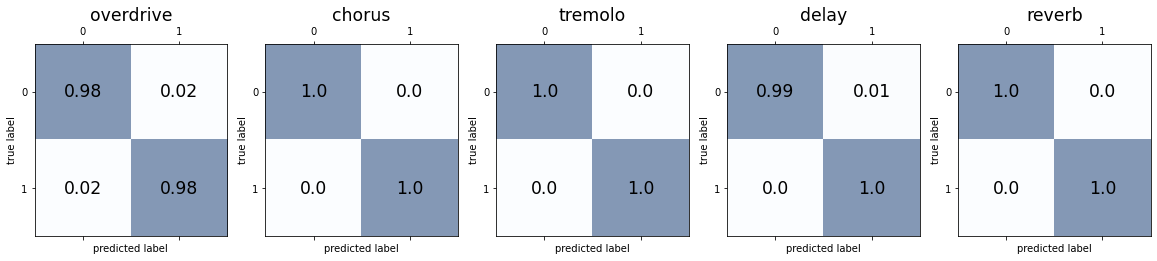

In [ ]:
# plot confusion matrices
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import normalize


def normalize_confusion_matrix(matrix):
  return normalize(matrix, axis=1, norm='l1')

def plot_confusion_matrices_from_list(confusion_matrices_array, normalize=False, decimals=2, save=False, name=None):

  confusion_matrices_array = np.array(confusion_matrices_list)
  if normalize:
    confusion_matrices_array = np.array(list(map(normalize_confusion_matrix, confusion_matrices_array)))
    confusion_matrices_array = np.around(confusion_matrices_array, decimals=decimals)
  else:
    confusion_matrices_array = np.around(confusion_matrices_array, decimals=decimals)

  # plot matrices
  fig, ax = plt.subplots(1, 5, figsize=(20, 5))
  labels = ['overdrive', 'chorus', 'tremolo', 'delay', 'reverb']
  for index, confusion_matrix in enumerate(confusion_matrices_array):
    ax[index].matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confusion_matrix.shape[0]):
      for j in range(confusion_matrix.shape[1]):
          ax[index].text(x=j, y=i, s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
          ax[index].set_title(labels[index], size='xx-large')
          ax[index].set_xlabel('predicted label')
          ax[index].set_ylabel('true label')
 
  if save:
    save_path = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/4__plots/' + name + '.png'
    plt.savefig(save_path)
  plt.show()

plot_confusion_matrices_from_list(confusion_matrices_list, True, decimals=2, save=True, name=f'conf_matrices_dataset_{dataset_number}')

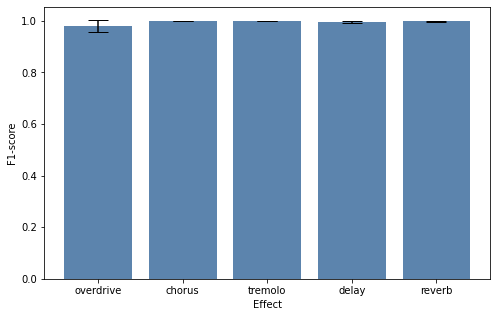

In [ ]:
# plot f1-score mean and variance for each effect separately

path = os.path.join(ROOTH_DEF, f'joint_guit_mean_std_dataset_{dataset_number}.json')

with open(path, 'r') as f:
  statistics_mean_var = json.load(f)

mean_values = []
std_values = []

for effect in EFFECTS:
  mean = statistics_mean_var[effect]['f1-score']['mean']
  std = statistics_mean_var[effect]['f1-score']['std']
  mean_values.append(mean)
  std_values.append(std)

# actual plot
def plot_bar_plot_mean_std(labels, mean_values, std_values, save=False, name=None):
  plt.figure(figsize=(8,5))
  plt.bar(labels, mean_values, yerr=std_values, color=(0.2, 0.4, 0.6, 0.8),  ecolor='black', capsize=10)
  plt.ylabel('F1-score')
  plt.xlabel('Effect')

  if save:
    save_path = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/4__plots/' + name + '.png'
    plt.savefig(save_path)
  plt.show()

plot_bar_plot_mean_std(EFFECTS, mean_values, std_values, save=True, name=f'f1_dataset_{dataset_number}_all_guit')


#### GET F1 SCORE FOR EACH GUITAR AND EFFECT SEPARATELY (AVERAGING AMONG DATASETS)

In [ ]:
# get f1-score value for each guitar separately NEW
import json
from pprint import pprint

EFFECTS = ['overdrive', 'chorus', 'tremolo', 'delay', 'reverb']
GUITARS = ['les', 'prs','str', 'tele']

path_dataset_1 = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/1__dataset_1_fixed/joint_guit_all_stats_dataset_1.json'
path_dataset_2 = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/2__dataset_2_params/joint_guit_all_stats_dataset_2.json'
path_dataset_3 = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/3__dataset_3_position/joint_guit_all_stats_dataset_3.json'

stats_all_datasets = []

with open(path_dataset_1, 'r') as f:
  stats_dataset_1 = json.load(f)
  stats_all_datasets.append(stats_dataset_1)

with open(path_dataset_2, 'r') as f:
  stats_dataset_2 = json.load(f)
  stats_all_datasets.append(stats_dataset_2)

with open(path_dataset_3, 'r') as f:
  stats_dataset_3 = json.load(f)
  stats_all_datasets.append(stats_dataset_3)


In [ ]:
les_f1_all_datasets = {'overdrive':[], 'chorus':[], 'tremolo':[], 'delay':[], 'reverb':[]}
prs_f1_all_datasets = {'overdrive':[], 'chorus':[], 'tremolo':[], 'delay':[], 'reverb':[]}
str_f1_all_datasets = {'overdrive':[], 'chorus':[], 'tremolo':[], 'delay':[], 'reverb':[]}
tele_f1_all_datasets = {'overdrive':[], 'chorus':[], 'tremolo':[], 'delay':[], 'reverb':[]}

# pprint(stats_all_datasets[0]['chorus']['f1-score'], sort_dicts=False)
# pprint(stats_all_datasets[1]['chorus']['f1-score'], sort_dicts=False)
# pprint(stats_all_datasets[2]['chorus']['f1-score'], sort_dicts=False)

# les
for stat_single_dataset in stats_all_datasets:
  for effect in EFFECTS:
    for i in (0,1,2):
      f1_value = stat_single_dataset[effect]['f1-score'][i]
      les_f1_all_datasets[effect].append(f1_value)

# prs
for stat_single_dataset in stats_all_datasets:
  for effect in EFFECTS:
    for i in (3,4,5):
      f1_value = stat_single_dataset[effect]['f1-score'][i]
      prs_f1_all_datasets[effect].append(f1_value)

# str
for stat_single_dataset in stats_all_datasets:
  for effect in EFFECTS:
    for i in (6,7,8):
      f1_value = stat_single_dataset[effect]['f1-score'][i]
      str_f1_all_datasets[effect].append(f1_value)

# tele
for stat_single_dataset in stats_all_datasets:
  for effect in EFFECTS:
    for i in (9,10,11):
      f1_value = stat_single_dataset[effect]['f1-score'][i]
      tele_f1_all_datasets[effect].append(f1_value)


pprint(les_f1_all_datasets, sort_dicts=False)


{'overdrive': [0.978287841191067,
               0.9131058216231717,
               0.9628275441803779,
               0.97796817625459,
               0.9310445155659005,
               0.9922287845819087,
               0.9517282479141835,
               0.8577563070316693,
               0.8786381109280614],
 'chorus': [0.9993753903810119,
            0.9987515605493134,
            0.9993753903810119,
            0.9867004433185561,
            0.9737010904425913,
            0.9767156862745098,
            0.9893216080402011,
            0.9828353464717101,
            0.9877397044954417],
 'tremolo': [0.999687597625742,
             0.99812734082397,
             0.9993746091307067,
             0.9531297248261265,
             0.9638407778790642,
             0.9657747355320472,
             0.9204413472706156,
             0.9511220411927451,
             0.8689509007417873],
 'delay': [0.9959260419931056,
           0.9922480620155039,
           0.9812940815700706,
          

In [ ]:
import numpy as np

les_f1_mean_std =  {'overdrive':{}, 'chorus':{}, 'tremolo':{}, 'delay':{}, 'reverb':{}}
prs_f1_mean_std =  {'overdrive':{}, 'chorus':{}, 'tremolo':{}, 'delay':{}, 'reverb':{}}
str_f1_mean_std =  {'overdrive':{}, 'chorus':{}, 'tremolo':{}, 'delay':{}, 'reverb':{}}
tele_f1_mean_std = {'overdrive':{}, 'chorus':{}, 'tremolo':{}, 'delay':{}, 'reverb':{}}


for effect in EFFECTS:
  mean = np.mean(les_f1_all_datasets[effect])
  std = np.std(les_f1_all_datasets[effect])
  les_f1_mean_std[effect]['mean'] = mean
  les_f1_mean_std[effect]['std'] = std

for effect in EFFECTS:
  mean = np.mean(prs_f1_all_datasets[effect])
  std = np.std(prs_f1_all_datasets[effect])
  prs_f1_mean_std[effect]['mean'] = mean
  prs_f1_mean_std[effect]['std'] = std

for effect in EFFECTS:
  mean = np.mean(str_f1_all_datasets[effect])
  std = np.std(str_f1_all_datasets[effect])
  str_f1_mean_std[effect]['mean'] = mean
  str_f1_mean_std[effect]['std'] = std

for effect in EFFECTS:
  mean = np.mean(tele_f1_all_datasets[effect])
  std = np.std(tele_f1_all_datasets[effect])
  tele_f1_mean_std[effect]['mean'] = mean
  tele_f1_mean_std[effect]['std'] = std



f1_mean_std = {'les': les_f1_mean_std, 'prs': prs_f1_mean_std,'str': str_f1_mean_std, 'tele': tele_f1_mean_std}

pprint(f1_mean_std, sort_dicts=False)

{'les': {'overdrive': {'mean': 0.9381761499189921, 'std': 0.0442177714851508},
         'chorus': {'mean': 0.988279580039372, 'std': 0.009041036247663383},
         'tremolo': {'mean': 0.9578276750025339, 'std': 0.04022938652966638},
         'delay': {'mean': 0.9678640337927242, 'std': 0.028980121921392134},
         'reverb': {'mean': 0.9975538524104655, 'std': 0.0033562572621563583}},
 'prs': {'overdrive': {'mean': 0.9925746265897144, 'std': 0.01078547578135084},
         'chorus': {'mean': 0.9826764851423947, 'std': 0.025170176509837605},
         'tremolo': {'mean': 0.9684930420114648, 'std': 0.02311418336828296},
         'delay': {'mean': 0.9802796323002442, 'std': 0.016243396992604492},
         'reverb': {'mean': 0.9996875323995494, 'std': 0.0003293013764875062}},
 'str': {'overdrive': {'mean': 0.9842634277430284, 'std': 0.00868928653341254},
         'chorus': {'mean': 0.9786477300605352, 'std': 0.03636472205105556},
         'tremolo': {'mean': 0.9483330521941598, 'std': 0.0

In [ ]:
# save mean vector and std vector for each effect
# the position on the list indivate the corresponding guitar

# for each effect I have the mean value for each guitar es [0.9, 0.83, 0.88, 0.8]
mean_dict_each_effect = {'overdrive':[], 'chorus':[], 'tremolo':[], 'delay':[], 'reverb':[]}
std_dict_each_effect = {'overdrive':[], 'chorus':[], 'tremolo':[], 'delay':[], 'reverb':[]}

for effect in EFFECTS:
  for guitar in GUITARS:

    mean = f1_mean_std[guitar][effect]['mean']
    std = f1_mean_std[guitar][effect]['std']

    mean_dict_each_effect[effect].append(mean)
    std_dict_each_effect[effect].append(std)


pprint(mean_dict_each_effect, sort_dicts=False)
#pprint(std_dict_each_effect, sort_dicts=False)

{'overdrive': [0.9381761499189921,
               0.9925746265897144,
               0.9842634277430284,
               0.9827027920698987],
 'chorus': [0.988279580039372,
            0.9826764851423947,
            0.9786477300605352,
            0.9885669465760935],
 'tremolo': [0.9578276750025339,
             0.9684930420114648,
             0.9483330521941598,
             0.968338395504088],
 'delay': [0.9678640337927242,
           0.9802796323002442,
           0.9711784234151639,
           0.9843432486048366],
 'reverb': [0.9975538524104655,
            0.9996875323995494,
            0.9948729671505152,
            0.9986130794291529]}


In [ ]:
a = 0.999687597625742 + 0.99812734082397 + 0.9993746091307067 + 0.9531297248261265 + 0.9638407778790642 + 0.9657747355320472 + 0.9204413472706156 + 0.9511220411927451 + 0.8689509007417873
b = a/9
a2 = 0.9931719428926133 + 0.9931719428926133 + 0.995334370139969 + 0.9878542510121456 + 0.984934086629002 + 0.984481688392303 + 0.9482758620689655 + 0.9469943737044715 + 0.9063872930043934
b2 = a2/9
b2

0.9711784234151639

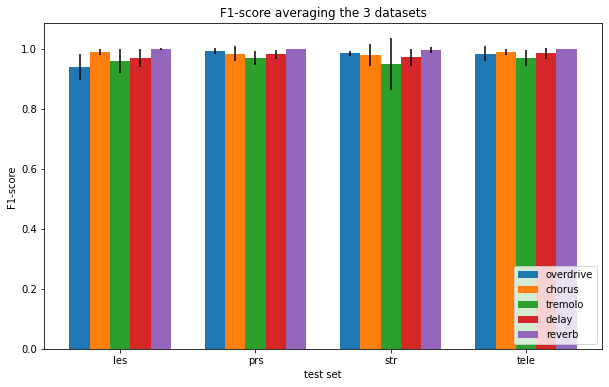

In [ ]:
import matplotlib.pyplot as plt

# constants
x_values = np.arange(4)
width = 0.15
plt.figure(figsize=(10, 6))

# create bars
bar_position = (-2,-1,0,1,2)
for effect, bar_pos in zip(EFFECTS, bar_position):
  plt.bar(x_values + bar_pos*width, mean_dict_each_effect[effect], yerr=std_dict_each_effect[effect], width=width)

plt.xticks(x_values, GUITARS)
plt.legend(EFFECTS, loc='lower right')
plt.title('F1-score averaging the 3 datasets')
plt.ylabel('F1-score')
plt.xlabel('test set')

save_path = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/4__plots/' + 'f1_each_guitar_each_effect' + '.png'
plt.savefig(save_path)



plt.show()


### new not used

In [ ]:
# get f1-score value for each guitar separately
import os
import json
import numpy as np
from pprint import pprint

GUITARS = ['les', 'prs','str', 'tele']
EFFECTS = ['overdrive', 'chorus', 'tremolo', 'delay', 'reverb']
STATISTICS = ['precision', 'recall', 'f1-score', 'support']

path_dataset_1 = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/1__dataset_1_fixed/statistics__dataset_1__guitar_'
path_dataset_2 = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/2__dataset_2_params/statistics__dataset_2__guitar_'
path_dataset_3 = '/content/drive/MyDrive/Colab Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/3__dataset_3_position/statistics__dataset_3__guitar_'
end_path = '__runs_3.json'

# get path for each guitar and dataset
paths_each_guitar = {'les': [], 'prs': [],'str': [], 'tele': []}
for guitar in GUITARS:
  path_1 = path_dataset_1 + guitar + end_path
  path_2 = path_dataset_2 + guitar + end_path
  path_3 = path_dataset_3 + guitar + end_path
  paths_each_guitar[guitar] = [path_1, path_2, path_3]

pprint(paths_each_guitar, sort_dicts=False)

{'les': ['/content/drive/MyDrive/Colab '
         'Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/1__dataset_1_fixed/statistics__dataset_1__guitar_les__runs_3.json',
         '/content/drive/MyDrive/Colab '
         'Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/2__dataset_2_params/statistics__dataset_2__guitar_les__runs_3.json',
         '/content/drive/MyDrive/Colab '
         'Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/3__dataset_3_position/statistics__dataset_3__guitar_les__runs_3.json'],
 'prs': ['/content/drive/MyDrive/Colab '
         'Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/1__dataset_1_fixed/statistics__dataset_1__guitar_prs__runs_3.json',
         '/content/drive/MyDrive/Colab '
         'Notebooks/5__paper_effects/3__statistics/2__each_guitar_as_test/2__dataset_2_params/statistics__dataset_2__guitar_prs__runs_3.json',
         '/content/drive/MyDrive/Colab '
         'Notebooks/5__paper_effects/3

In [ ]:
statistics_each_guitar = {'les': [], 'prs': [],'str': [], 'tele': []}

for guitar in GUITARS:

  for file_index in range(3):
    path = paths_each_guitar[guitar][file_index]
    with open(path, 'r') as f:
      statistics = json.load(f)
    
    for element in statistics:
      statistics_each_guitar[guitar].append(element)
    
pprint(statistics_each_guitar, sort_dicts=False)

{'les': [{'overdrive': {'precision': 0.9710591133004927,
                        'recall': 0.985625,
                        'f1-score': 0.978287841191067,
                        'support': 1600},
          'chorus': {'precision': 0.9987515605493134,
                     'recall': 1.0,
                     'f1-score': 0.9993753903810119,
                     'support': 1600},
          'tremolo': {'precision': 0.9993753903810119,
                      'recall': 1.0,
                      'f1-score': 0.999687597625742,
                      'support': 1600},
          'delay': {'precision': 0.9987429289754871,
                    'recall': 0.993125,
                    'f1-score': 0.9959260419931056,
                    'support': 1600},
          'reverb': {'precision': 1.0,
                     'recall': 1.0,
                     'f1-score': 1.0,
                     'support': 1600},
          'micro avg': {'precision': 0.9935145921676228,
                        'recall': 0.99575,


In [ ]:
# for each guitar find the f1-score for each effect
for guitar in GUITARS:
  print(len(statistics_each_guitar[guitar]))

  break

9
